In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../Data/US_UR.csv')
df = df.dropna()
df


,Yearmon,USUnemploymentRate
0,1-1986,6.7
1,2-1986,7.2
2,3-1986,7.2
3,4-1986,7.1
4,5-1986,7.2
...,...,...
423,4-2021,6.1
424,5-2021,5.8
425,6-2021,5.9
426,7-2021,5.4


In [3]:
df['Yearmon'] = pd.to_datetime(df['Yearmon'])
df.set_index('Yearmon', inplace=True)


In [4]:
df

,USUnemploymentRate
Yearmon,
1986-01-01,6.7
1986-02-01,7.2
1986-03-01,7.2
1986-04-01,7.1
1986-05-01,7.2
...,...
2021-04-01,6.1
2021-05-01,5.8
2021-06-01,5.9


In [5]:
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 16

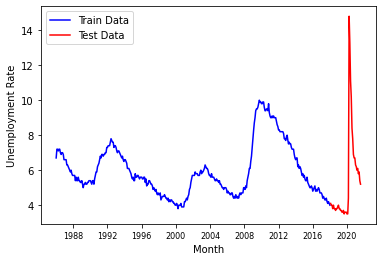

In [6]:
# df_close = np.log(df['Close'])
train_data, test_data = df[:int(len(df)*0.9)], df[int(len(df)*0.9):]
plt.plot(train_data, 'blue', label='Train Data')
plt.plot(test_data, 'red', label='Test Data')
plt.xlabel('Month')
plt.ylabel('Unemployment Rate')
plt.xticks(fontsize=8)
plt.legend()
plt.show()


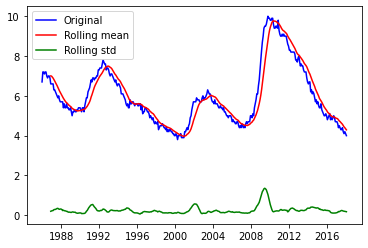

In [7]:
#Biểu đồ lịch sử so sánh giá đóng cửa với giá trị trung bình và độ lệch chuẩn của 12 kỳ trước đó
rolmean = train_data.rolling(12).mean()     
rolstd = train_data.rolling(12).std() #Độ lệch chuẩn: Độ giao động so với lịch sử giá trong quá khứ
plt.plot(train_data, 'blue', label='Original')
plt.plot(rolmean, 'red', label='Rolling mean')
plt.plot(rolstd, 'green', label='Rolling std')
plt.xticks(rotation=0)
plt.legend()
plt.show()

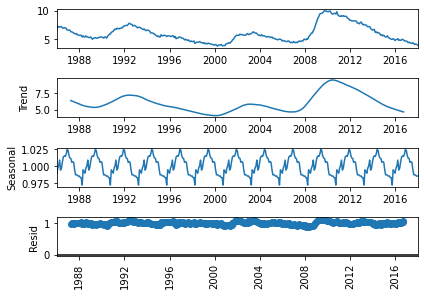

In [8]:
# a) Phân rã Chuỗi thời gian
decompose_results = seasonal_decompose(train_data , model='multiplicative', period=30)
decompose_results.plot()
plt.xticks(rotation=90)
plt.show()

# --> Doanh số cửa hàng có xu hướng tăng theo thời gian, đặc biệt tăng mạnh từ năm 2017 đến cuối 2018

In [9]:
# Kiểm định tính dừng của dữ liệu


def adf_test(data):
    indices = ["ADF: Test statistic", "p values", "# of lags", "# of Observations"]
    test = adfuller(data, autolag='AIC')
    results = pd.Series(test[:4], index=indices)
    for key, value in test[4].items():
        results[f'Critical value: ({key})']=value
    return results

def kpss_test(data):
    indices = ["KPSS: Test statistic", "p values", "# of lags"]
    test = kpss(data)
    results = pd.Series(test[:3], index=indices)
    for key, value in test[3].items():
        results[f'Critical value: ({key})']=value
    return results


In [10]:
print(adf_test(train_data))
print('---------'*5)
print(kpss_test(train_data))

ADF: Test statistic       -2.695189
p values                   0.074875
# of lags                  6.000000
# of Observations        378.000000
Critical value: (1%)      -3.447769
Critical value: (5%)      -2.869217
Critical value: (10%)     -2.570860
dtype: float64
---------------------------------------------
KPSS: Test statistic       0.282551
p values                   0.100000
# of lags                 11.000000
Critical value: (10%)      0.347000
Critical value: (5%)       0.463000
Critical value: (2.5%)     0.574000
Critical value: (1%)       0.739000
dtype: float64


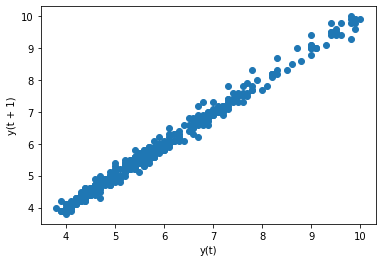

In [11]:
# Kiểm định tự tương quan trên dữ liệu

pd.plotting.lag_plot(train_data)
plt.show()

# --> Sự tương quan không mạnh doanh số giữa các tháng

In [12]:
print(adf_test(train_data))
print(kpss_test(train_data))

ADF: Test statistic       -2.695189
p values                   0.074875
# of lags                  6.000000
# of Observations        378.000000
Critical value: (1%)      -3.447769
Critical value: (5%)      -2.869217
Critical value: (10%)     -2.570860
dtype: float64
KPSS: Test statistic       0.282551
p values                   0.100000
# of lags                 11.000000
Critical value: (10%)      0.347000
Critical value: (5%)       0.463000
Critical value: (2.5%)     0.574000
Critical value: (1%)       0.739000
dtype: float64


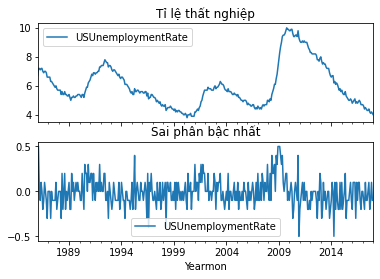

In [13]:
#Chuyển đổi chuổi dừng
# Tính sai phân bậc 1 dữ liệu train
diff = train_data.diff().dropna()
# Biểu đồ thể hiện dữ liệu ban đầu và sau khi lấy sai phân
fig, ax = plt.subplots(2, sharex='all')
train_data.plot(ax=ax[0], title='Tỉ lệ thất nghiệp')
diff.plot(ax=ax[1], title='Sai phân bậc nhất')
plt.show()

ADF: Test statistic       -3.931095
p values                   0.001818
# of lags                  5.000000
# of Observations        378.000000
Critical value: (1%)      -3.447769
Critical value: (5%)      -2.869217
Critical value: (10%)     -2.570860
dtype: float64
KPSS: Test statistic      0.13499
p values                  0.10000
# of lags                 9.00000
Critical value: (10%)     0.34700
Critical value: (5%)      0.46300
Critical value: (2.5%)    0.57400
Critical value: (1%)      0.73900
dtype: float64


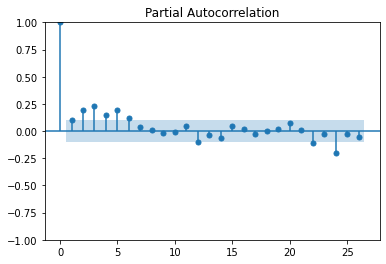

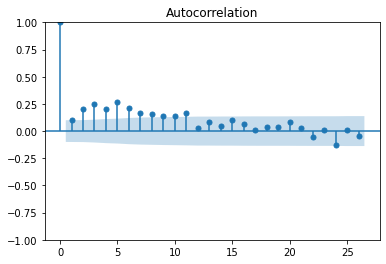

In [14]:
print(adf_test(diff))
print(kpss_test(diff))
plot_pacf(diff)
plot_acf(diff)
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-395.632, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-336.175, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-338.321, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-337.195, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-337.390, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-387.895, Time=0.59 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-386.881, Time=1.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-393.559, Time=0.91 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-378.515, Time=0.34 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-393.996, Time=0.46 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-390.572, Time=0.48 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-391.906, Time=1.22 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-397.547, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

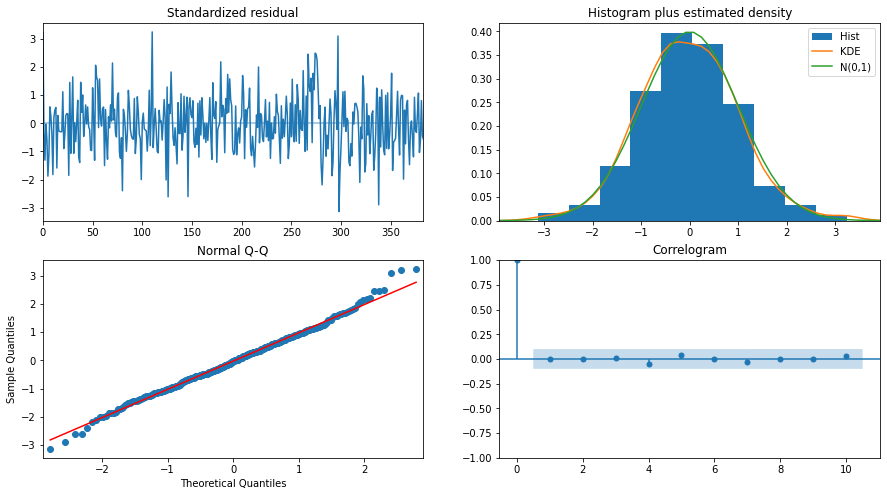

In [15]:
# Sử dụng mo hình ARIMA để dự đoán 

# Xác định tham số p, d, q cho mô hình ARIMA
stepwise_fit = auto_arima(train_data, trace=True, suppress_warning=True)
print(stepwise_fit.summary())
stepwise_fit.plot_diagnostics(figsize=(15,8))
plt.show()

In [16]:
# Tao model
model = ARIMA(train_data, order=(2,1,2))
fitted = model.fit()
print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:     USUnemploymentRate   No. Observations:                  385
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 203.773
Date:                Thu, 11 Aug 2022   AIC                           -397.547
Time:                        11:42:59   BIC                           -377.793
Sample:                    01-01-1986   HQIC                          -389.712
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4208      0.148      9.623      0.000       1.131       1.710
ar.L2         -0.4867      0.144     -3.382      0.001      -0.769      -0.205
ma.L1         -1.4822      0.131    -11.355      0.0

In [17]:
# Forcast
fc = fitted.forecast(len(test_data), alpha=0.05, index=test_data.index)
se = fitted.bse
conf = fitted.get_forecast(len(test_data), alpha=0.05, index=test_data.index).conf_int()
# print(type(fc))


In [18]:
print(fc, se, conf)

Yearmon
2018-02-01    3.983224
2018-03-01    3.955074
2018-04-01    3.923243
2018-05-01    3.891717
2018-06-01    3.862414
2018-07-01    3.836124
2018-08-01    3.813030
2018-09-01    3.793013
2018-10-01    3.775811
2018-11-01    3.761112
2018-12-01    3.748599
2019-01-01    3.737974
2019-02-01    3.728968
2019-03-01    3.721342
2019-04-01    3.714890
2019-05-01    3.709434
2019-06-01    3.704823
2019-07-01    3.700926
2019-08-01    3.697633
2019-09-01    3.694851
2019-10-01    3.692501
2019-11-01    3.690516
2019-12-01    3.688839
2020-01-01    3.687423
2020-02-01    3.686227
2020-03-01    3.685216
2020-04-01    3.684363
2020-05-01    3.683642
2020-06-01    3.683033
2020-07-01    3.682519
2020-08-01    3.682085
2020-09-01    3.681718
2020-10-01    3.681408
2020-11-01    3.681146
2020-12-01    3.680925
2021-01-01    3.680738
2021-02-01    3.680581
2021-03-01    3.680448
2021-04-01    3.680335
2021-05-01    3.680240
2021-06-01    3.680160
2021-07-01    3.680092
2021-08-01    3.680035
Nam

In [19]:

lower_series = pd.Series(conf['lower USUnemploymentRate'], index=test_data.index)
upper_series = pd.Series(conf['upper USUnemploymentRate'], index=test_data.index)
# print(lower_series)


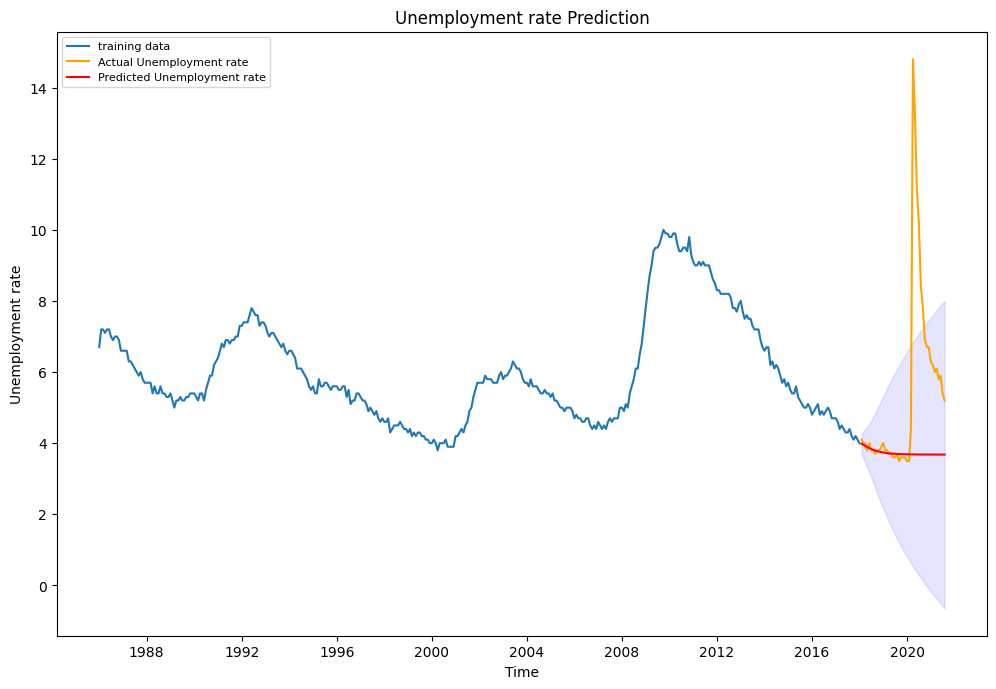

In [20]:
plt.figure(figsize=(12,8), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'orange', label='Actual Unemployment rate')
plt.plot(fc, color = 'red',label='Predicted Unemployment rate')
plt.fill_between(lower_series.index, lower_series, upper_series, color='b', alpha=.10)
plt.title('Unemployment rate Prediction')
plt.xlabel('Time')
plt.ylabel('Unemployment rate')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(rotation=0)
plt.show()

In [21]:
import pickle
with open('./models/model_TimeSeries_ARIMA_UnempRate', 'wb') as f:
    pickle.dump(model, f)